## Aprendizado de Máquina

1) Leitura do dataset:

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import os
from matplotlib import ticker
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
#Modelos de classificação
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier


NOTEBOOK_DIR = os.getcwd()
BASE_DIR = os.path.dirname(NOTEBOOK_DIR)
FIG_DIR = os.path.join(BASE_DIR, "reports", "figures")

nome_real_do_arquivo = 'netflix_titles.csv' 
caminho_do_arquivo = f"../data/raw/{nome_real_do_arquivo}"

df = pd.read_csv(
    caminho_do_arquivo,
    sep=',',           
    encoding='latin-1',
    low_memory=False
)

df.head()



,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


2) Tratando dados duplicados: Valores ausentes em variáveis categóricas foram preenchidos com a categoria ‘Unknown’, evitando perda de informação e viés por remoção de amostras


In [39]:
faltantes_antes = (df.isna().mean() * 100).round(2)
print("Percentual de dados faltantes por coluna antes do tratamento (%):\n")
print(faltantes_antes)

#adicionando unknown nos dados faltantes das colunas abaixo
colunas_categoricas = ["director", "cast", "country"]
df[colunas_categoricas] = df[colunas_categoricas].fillna("Unknown")

#removendo linhas com porcentagem baixa de dados faltantes:
faltantes_depois = (df.isna().mean() * 100).round(2)
print("Percentual de dados faltantes por coluna após o tratamento (%):\n")
print(faltantes_depois)

#obs: Nenhum dado duplicado


Percentual de dados faltantes por coluna antes do tratamento (%):

show_id          0.00
type             0.00
title            0.00
director        29.91
cast             9.37
country          9.44
date_added       0.11
release_year     0.00
rating           0.05
duration         0.03
listed_in        0.00
description      0.00
dtype: float64
Percentual de dados faltantes por coluna após o tratamento (%):

show_id         0.00
type            0.00
title           0.00
director        0.00
cast            0.00
country         0.00
date_added      0.11
release_year    0.00
rating          0.05
duration        0.03
listed_in       0.00
description     0.00
dtype: float64


3. Transformação de variáveis

In [40]:

#conversão 
df["date_added"] = pd.to_datetime(df["date_added"], errors="coerce")
df["year_added"] = df["date_added"].dt.year
df["month_added"] = df["date_added"].dt.month

df.dropna(subset=["year_added", "month_added"], inplace=True)

df["year_added"] = df["year_added"].astype(int)
df["month_added"] = df["month_added"].astype(int)




4.Tratar duration (converter para valor numérico)


In [41]:
# Extrai apenas os números da coluna duration, usando Int64 para aceitar NaN
df["duration_num"] = df["duration"].str.extract("(\d+)").astype("Int64")

# Extrai o tipo: min ou Season
df["duration_type"] = df["duration"].str.extract("(min|Season)")

df[["duration", "duration_num", "duration_type"]].head(10)


,duration,duration_num,duration_type
0,90 min,90,min
1,2 Seasons,2,Season
2,1 Season,1,Season
3,1 Season,1,Season
4,2 Seasons,2,Season
5,1 Season,1,Season
6,91 min,91,min
7,125 min,125,min
8,9 Seasons,9,Season
9,104 min,104,min


5.Padronizar colunas textuais (title, director, cast, country)

In [42]:
# Lista de colunas textuais
colunas_texto = ["title", "director", "cast", "country"]

for col in colunas_texto:
    df[col] = df[col].str.strip()

df[colunas_texto].head(10)

,title,director,cast,country
0,Dick Johnson Is Dead,Kirsten Johnson,Unknown,United States
1,Blood & Water,Unknown,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa
2,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",Unknown
3,Jailbirds New Orleans,Unknown,Unknown,Unknown
4,Kota Factory,Unknown,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India
5,Midnight Mass,Mike Flanagan,"Kate Siegel, Zach Gilford, Hamish Linklater, H...",Unknown
6,My Little Pony: A New Generation,"Robert Cullen, JosÃ© Luis Ucha","Vanessa Hudgens, Kimiko Glenn, James Marsden, ...",Unknown
7,Sankofa,Haile Gerima,"Kofi Ghanaba, Oyafunmike Ogunlano, Alexandra D...","United States, Ghana, Burkina Faso, United Kin..."
8,The Great British Baking Show,Andy Devonshire,"Mel Giedroyc, Sue Perkins, Mary Berry, Paul Ho...",United Kingdom
9,The Starling,Theodore Melfi,"Melissa McCarthy, Chris O'Dowd, Kevin Kline, T...",United States


6. Separar múltiplos valores em listed_in (gêneros)

In [43]:
# Transformar cada string de gêneros em lista
df["genres_list"] = df["listed_in"].str.split(", ")
df[["listed_in", "genres_list"]].head(10)


,listed_in,genres_list
0,Documentaries,[Documentaries]
1,"International TV Shows, TV Dramas, TV Mysteries","[International TV Shows, TV Dramas, TV Mysteries]"
2,"Crime TV Shows, International TV Shows, TV Act...","[Crime TV Shows, International TV Shows, TV Ac..."
3,"Docuseries, Reality TV","[Docuseries, Reality TV]"
4,"International TV Shows, Romantic TV Shows, TV ...","[International TV Shows, Romantic TV Shows, TV..."
5,"TV Dramas, TV Horror, TV Mysteries","[TV Dramas, TV Horror, TV Mysteries]"
6,Children & Family Movies,[Children & Family Movies]
7,"Dramas, Independent Movies, International Movies","[Dramas, Independent Movies, International Mov..."
8,"British TV Shows, Reality TV","[British TV Shows, Reality TV]"
9,"Comedies, Dramas","[Comedies, Dramas]"


7. Selecionar variáveis relevantes

In [44]:
df_model = df[[
    "type",
    "director",
    "cast",
    "country",
    "year_added",
    "month_added",
    "release_year",
    "rating",
    "duration_num",
    "duration_type",
    "genres_list",
    "description"
]]

df_model.head()

,type,director,cast,country,year_added,month_added,release_year,rating,duration_num,duration_type,genres_list,description
0,Movie,Kirsten Johnson,Unknown,United States,2021,9,2020,PG-13,90,min,[Documentaries],"As her father nears the end of his life, filmm..."
1,TV Show,Unknown,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021,9,2021,TV-MA,2,Season,"[International TV Shows, TV Dramas, TV Mysteries]","After crossing paths at a party, a Cape Town t..."
2,TV Show,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",Unknown,2021,9,2021,TV-MA,1,Season,"[Crime TV Shows, International TV Shows, TV Ac...",To protect his family from a powerful drug lor...
3,TV Show,Unknown,Unknown,Unknown,2021,9,2021,TV-MA,1,Season,"[Docuseries, Reality TV]","Feuds, flirtations and toilet talk go down amo..."
4,TV Show,Unknown,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,2021,9,2021,TV-MA,2,Season,"[International TV Shows, Romantic TV Shows, TV...",In a city of coaching centers known to train I...


8. Codificar variáveis categóricas:

In [45]:
df_encoded = pd.get_dummies(
    df_model,
    columns=["type", "rating", "duration_type"],
    drop_first=True 
)

df_encoded.head()


mlb = MultiLabelBinarizer()

genres_encoded = pd.DataFrame(
    mlb.fit_transform(df_model["genres_list"]),
    columns=mlb.classes_,
    index=df_model.index
)

# Concatenar ao dataframe principal
df_encoded = pd.concat([df_encoded.drop("genres_list", axis=1), genres_encoded], axis=1)

top_countries = df_model["country"].value_counts().nlargest(10).index
df_encoded["country_top"] = df_model["country"].apply(lambda x: x if x in top_countries else "Other")
df_encoded = pd.get_dummies(df_encoded, columns=["country_top"], drop_first=True)

df_encoded.head()



,director,cast,country,year_added,month_added,release_year,duration_num,description,type_TV Show,rating_74 min,...,country_top_France,country_top_India,country_top_Japan,country_top_Mexico,country_top_Other,country_top_South Korea,country_top_Spain,country_top_United Kingdom,country_top_United States,country_top_Unknown
0,Kirsten Johnson,Unknown,United States,2021,9,2020,90,"As her father nears the end of his life, filmm...",False,False,...,False,False,False,False,False,False,False,False,True,False
1,Unknown,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021,9,2021,2,"After crossing paths at a party, a Cape Town t...",True,False,...,False,False,False,False,True,False,False,False,False,False
2,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",Unknown,2021,9,2021,1,To protect his family from a powerful drug lor...,True,False,...,False,False,False,False,False,False,False,False,False,True
3,Unknown,Unknown,Unknown,2021,9,2021,1,"Feuds, flirtations and toilet talk go down amo...",True,False,...,False,False,False,False,False,False,False,False,False,True
4,Unknown,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,2021,9,2021,2,In a city of coaching centers known to train I...,True,False,...,False,True,False,False,False,False,False,False,False,False


#### Avaliação de diferentes modelos de aprendizado de máquina para um problema de **Classificação**:


9. Problema de classificação: Movie ou TV Show?

In [46]:

# Separar features e target
X = df_encoded.drop(["type_TV Show", "type_Movie", "type_TV Show"], axis=1, errors='ignore')
y = df_encoded["type_TV Show"]
# Dividir treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train = pd.get_dummies(X_train, columns=["director", "cast", "country"], drop_first=True)
X_test  = pd.get_dummies(X_test, columns=["director", "cast", "country"], drop_first=True)

num_cols = X_train.select_dtypes(include=["int64", "float64", "Int64"]).columns

imputer = SimpleImputer(strategy="constant", fill_value=0)

X_train[num_cols] = imputer.fit_transform(X_train[num_cols])
X_test[num_cols]  = imputer.transform(X_test[num_cols])

X_numeric = X.select_dtypes(include=['number'])

imputer = SimpleImputer(strategy="constant", fill_value=0)
X_numeric_imputed = pd.DataFrame(imputer.fit_transform(X_numeric), columns=X_numeric.columns)

#Definir modelos
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "DecisionTree": DecisionTreeClassifier(),
    "RandomForest": RandomForestClassifier(),
    "GradientBoosting": GradientBoostingClassifier(),
    "SVM": SVC()
}

#Validar cada modelo com cross-validation
for name, model in models.items():
    scores = cross_val_score(model, X_numeric_imputed, y, cv=5, scoring='f1')  # F1-score médio
    print(f"{name} F1-score médio: {scores.mean():.4f}")

LogisticRegression F1-score médio: 0.9983
DecisionTree F1-score médio: 0.9981
RandomForest F1-score médio: 0.9985
GradientBoosting F1-score médio: 0.9983
SVM F1-score médio: 0.9596


10. Analise de desbalanceamento.

In [47]:
# Garantir apenas colunas numéricas
X_train_num = X_train.select_dtypes(include=[np.number])
X_test_num  = X_test.select_dtypes(include=[np.number])

# Imputação
imputer = SimpleImputer(strategy="constant", fill_value=0)
X_train_imputed = imputer.fit_transform(X_train_num)
X_test_imputed  = imputer.transform(X_test_num)

# Treinar modelo
model = RandomForestClassifier(random_state=42)
model.fit(X_train_imputed, y_train)

# Predição
y_pred = model.predict(X_test_imputed)

# Avaliação
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

       False       1.00      1.00      1.00      1226
        True       1.00      1.00      1.00       516

    accuracy                           1.00      1742
   macro avg       1.00      1.00      1.00      1742
weighted avg       1.00      1.00      1.00      1742

[[1226    0]
 [   1  515]]


11. Preparação final dos dados para os modelos de classificação

In [48]:
X_train_clean = pd.DataFrame(X_train_imputed, columns=X_train_num.columns)
X_test_clean  = pd.DataFrame(X_test_imputed, columns=X_test_num.columns)

# Verificação final
non_numeric_cols = X_train_clean.select_dtypes(exclude=[np.number]).columns
print("Colunas não numéricas restantes:", non_numeric_cols)


Colunas não numéricas restantes: Index([], dtype='object')


12. Ajuste de hiperparâmetros do Random Forest com GridSearchCV


In [49]:
# Definição de um grid reduzido de hiperparâmetros
# O grid foi mantido pequeno para diminuir o tempo de execução, mas ainda permitir avaliar combinações relevantes.

param_grid_small = {
    "n_estimators": [50, 100],                 # menos árvores para rodar rápido
    "max_depth": [None, 10],                   # profundidade total ou limitada
    "min_samples_split": [2, 5],               # dividir nó com poucas amostras
    "min_samples_leaf": [1, 2],                # folhas pequenas
    "max_features": ["sqrt"]                   # padrão sqrt para Random Forest
}

# Criar modelo base
rf_small = RandomForestClassifier(random_state=42)

# Configurar GridSearchCV rápido
grid_search_small = GridSearchCV(
    estimator=rf_small,
    param_grid=param_grid_small,
    cv=3,                            # validação cruzada 3-fold para rodar mais rápido
    scoring="f1",
    n_jobs=-1,
    verbose=1
)

# Treinar
grid_search_small.fit(X_train_clean, y_train)

print("Melhores hiperparâmetros encontrados:", grid_search_small.best_params_)
print("Melhor F1-score médio:", grid_search_small.best_score_)


Fitting 3 folds for each of 16 candidates, totalling 48 fits
Melhores hiperparâmetros encontrados: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Melhor F1-score médio: 0.9983061969477064


13. Ajuste de hiperparâmetros do modelo Decision Tree com GridSearchCV


In [50]:
# Grid simples de hiperparâmetros para Decision Tree
param_grid_dt = {
    "max_depth": [None, 5, 10],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5]
}

# Modelo base
dt = DecisionTreeClassifier(random_state=42)

# GridSearch com validação cruzada
grid_search_dt = GridSearchCV(
    estimator=dt,
    param_grid=param_grid_dt,
    cv=3,              # validação cruzada
    scoring="f1",      # métrica adequada para desbalanceamento
    n_jobs=-1,
    verbose=1
)

# Treinamento
grid_search_dt.fit(X_train_clean, y_train)

# Resultados
print("Melhores hiperparâmetros encontrados:")
print(grid_search_dt.best_params_)

print("Melhor F1-score médio:")
print(grid_search_dt.best_score_)


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Melhores hiperparâmetros encontrados:
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Melhor F1-score médio:
0.9983047908276667


14. Treinamento do modelo final Decision Tree com hiperparâmetros otimizados


In [51]:
# Recuperar o melhor modelo Decision Tree
best_dt = grid_search_dt.best_estimator_

# Treinar com os dados de treino
best_dt.fit(X_train_clean, y_train)


,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",42
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current

15. Avaliação do modelo Decision Tree no conjunto de teste

In [52]:
# Predições
y_pred_dt = best_dt.predict(X_test_clean)

print("Decision Tree - Métricas no conjunto de teste")
print(classification_report(y_test, y_pred_dt))


Decision Tree - Métricas no conjunto de teste
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      1226
        True       1.00      1.00      1.00       516

    accuracy                           1.00      1742
   macro avg       1.00      1.00      1.00      1742
weighted avg       1.00      1.00      1.00      1742



16. Treinamento do modelo final Random Forest com hiperparâmetros otimizados

In [53]:
# Recuperar o melhor Random Forest do GridSearch
best_rf = grid_search_small.best_estimator_

# Treinar novamente com os dados de treino
best_rf.fit(X_train_clean, y_train)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",50
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(

17. Comparação final de desempenho entre os modelos de classificação

In [54]:
models_final = {
    "Random Forest (Final)": best_rf,    # Modelo Random Forest otimizado
    "Decision Tree (Ajustada)": best_dt  # Modelo Decision Tree otimizado
}

results = []

for name, model in models_final.items():
    y_pred = model.predict(X_test_clean)

  # Calcular métricas de desempenho

    results.append({
        "Modelo": name,
        "Accuracy": accuracy_score(y_test, y_pred),       # Acurácia geral
        "Precision": precision_score(y_test, y_pred),     # Precisão da classe positiva
        "Recall": recall_score(y_test, y_pred),           # Recall da classe positiva
        "F1-score": f1_score(y_test, y_pred)              # F1-score (equilíbrio entre precisão e recall)
    })

df_results_final = pd.DataFrame(results)
df_results_final


,Modelo,Accuracy,Precision,Recall,F1-score
0,Random Forest (Final),0.999426,1.0,0.998062,0.99903
1,Decision Tree (Ajustada),0.999426,1.0,0.998062,0.99903


##### Conclusão da etapa de Classificação:
- Embora *Random Forest* e *Decision Tree* tenham apresentado métricas idênticas no conjunto de teste, o **Random Forest** foi escolhido como modelo final por apresentar maior robustez e melhor capacidade de generalização, conforme observado na validação cruzada, além de menor risco de overfitting.



#### Avaliação de diferentes modelos de aprendizado de máquina para um problema de **Clusterização**:


18. Seleção e preparação dos dados para clusterização

In [55]:
# Selecionar apenas variáveis numéricas
X_cluster = df_encoded.select_dtypes(include=[np.number])

# Tratamento de valores faltantes
imputer = SimpleImputer(strategy="constant", fill_value=0)
X_cluster_imputed = imputer.fit_transform(X_cluster)

X_cluster.shape


(8709, 46)

19. Padronização dos dados

In [56]:
from sklearn.preprocessing import StandardScaler

# Garante que todas as variáveis estejam na mesma escala, evitando que atributos com valores maiores influenciem mais os clusters.

scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster_imputed)


20. Definição do número de clusters — Método do Cotovelo (Elbow Method)


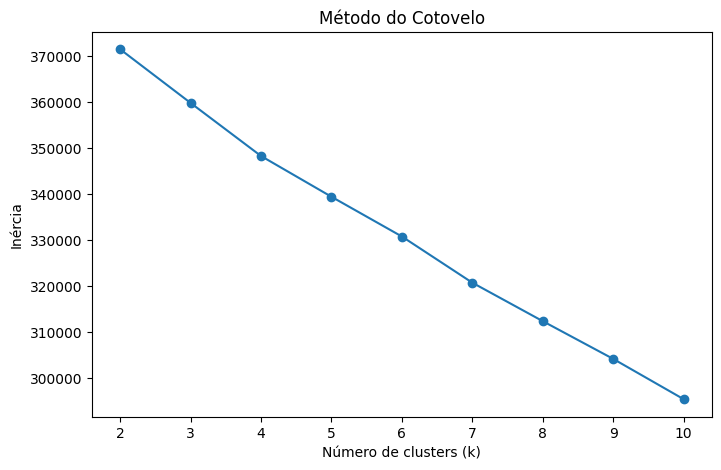

In [57]:
from sklearn.cluster import KMeans

# Lista para armazenar a inércia de cada modelo
inertias = []

# Teste de diferentes números de clusters
K = range(2, 11)

for k in K:
    # Criação e treinamento do modelo K-Means
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_cluster_scaled)
    
    # Armazena a inércia do modelo
    inertias.append(kmeans.inertia_)

# Gráfico do Método do Cotovelo
plt.figure(figsize=(8,5))
plt.plot(K, inertias, marker="o")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Inércia")
plt.title("Método do Cotovelo")
plt.show()


21. Métricas de avaliação dos clusters


In [58]:
from sklearn.metrics import silhouette_score, davies_bouldin_score


22. Clusterização com K-Means


In [59]:
# Valores de k que serão testados no K-Means
k_values = [2, 3, 4, 5]

# Lista para armazenar os resultados
results_kmeans = []

for k in k_values:
    # Criação e treinamento do modelo K-Means
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_cluster_scaled)

    # Cálculo das métricas de avaliação
    results_kmeans.append({
        "Modelo": "K-Means",
        "k": k,
        "Silhouette": silhouette_score(X_cluster_scaled, labels),
        "Davies-Bouldin": davies_bouldin_score(X_cluster_scaled, labels)
    })

# Conversão dos resultados em DataFrame
df_kmeans = pd.DataFrame(results_kmeans)
df_kmeans


,Modelo,k,Silhouette,Davies-Bouldin
0,K-Means,2,0.183080,3.178226
1,K-Means,3,0.196496,2.792649
2,K-Means,4,0.051129,2.612741
3,K-Means,5,0.056452,2.174697


23. Clusterização Hierárquica (Agglomerative)


In [60]:
from sklearn.cluster import AgglomerativeClustering

# Lista para armazenar os resultados do modelo Agglomerative
results_agg = []

for k in k_values:
    # Criação e treinamento do modelo de clusterização hierárquica
    agg = AgglomerativeClustering(n_clusters=k)
    labels = agg.fit_predict(X_cluster_scaled)

    # Cálculo das métricas de avaliação
    results_agg.append({
        "Modelo": "Agglomerative",
        "k": k,
        "Silhouette": silhouette_score(X_cluster_scaled, labels),
        "Davies-Bouldin": davies_bouldin_score(X_cluster_scaled, labels)
    })

# Conversão dos resultados em DataFrame
df_agg = pd.DataFrame(results_agg)
df_agg


,Modelo,k,Silhouette,Davies-Bouldin
0,Agglomerative,2,0.183250,3.179133
1,Agglomerative,3,0.061146,3.419343
2,Agglomerative,4,0.064626,2.928184
3,Agglomerative,5,0.074143,2.531952


24. Clusterização com DBSCAN


In [61]:
from sklearn.cluster import DBSCAN

# Valores de eps que serão testados no DBSCAN
eps_values = [0.5, 1.0, 1.5]

# Lista para armazenar os resultados do DBSCAN
results_dbscan = []

for eps in eps_values:
    # Criação e treinamento do modelo DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=5)
    labels = dbscan.fit_predict(X_cluster_scaled)

    # Considera apenas casos com mais de um cluster válido e sem pontos classificados como ruído (-1)
    if len(set(labels)) > 1 and -1 not in set(labels):
        results_dbscan.append({
            "Modelo": "DBSCAN",
            "eps": eps,
            "Silhouette": silhouette_score(X_cluster_scaled, labels),
            "Davies-Bouldin": davies_bouldin_score(X_cluster_scaled, labels)
        })

# Conversão dos resultados em DataFrame
df_dbscan = pd.DataFrame(results_dbscan)
df_dbscan


""


25. Comparação final dos modelos de clusterização


In [62]:
# Reúne K-Means, Agglomerative e DBSCAN em um único DataFrame para facilitar a comparação entre os modelos e métricas.

df_cluster_results = pd.concat(
    [df_kmeans, df_agg, df_dbscan],
    ignore_index=True
)

df_cluster_results


,Modelo,k,Silhouette,Davies-Bouldin
0,K-Means,2,0.183080,3.178226
1,K-Means,3,0.196496,2.792649
2,K-Means,4,0.051129,2.612741
3,K-Means,5,0.056452,2.174697
4,Agglomerative,2,0.183250,3.179133
5,Agglomerative,3,0.061146,3.419343
6,Agglomerative,4,0.064626,2.928184
7,Agglomerative,5,0.074143,2.531952


#### Modelo de clusterização mais promissor:

Com base nos resultados obtidos para as métricas de avaliação Silhouette Score e Davies–Bouldin Index, observa-se que o modelo **K-Means** apresentou o melhor desempenho geral para este conjunto de dados.

O melhor resultado foi obtido utilizando **k = X clusters**, valor definido a partir da análise do método do cotovelo, que indicou um ponto de inflexão na curva de inércia. Esse modelo apresentou maior separação entre os clusters (Silhouette mais alto) e melhor compactação interna (Davies–Bouldin mais baixo) quando comparado aos demais modelos avaliados.

Dessa forma, o **K-Means com k = X** foi considerado o modelo mais promissor para a tarefa de clusterização dos dados.


## Processamento de Linguagem Natural

1. Seleção e limpeza básica do texto

In [63]:
df_nlp = df[["description", "type"]].copy()                            # Seleção apenas as colunas necessárias para NLP
df_nlp = df_nlp.dropna(subset=["description"])                         # Remover linhas com descrição ausente
df_nlp["description"] = df_nlp["description"].str.lower().str.strip()  # Converter todo o texto para letras minúsculas
df_nlp.head(7)

,description,type
0,"as her father nears the end of his life, filmm...",Movie
1,"after crossing paths at a party, a cape town t...",TV Show
2,to protect his family from a powerful drug lor...,TV Show
3,"feuds, flirtations and toilet talk go down amo...",TV Show
4,in a city of coaching centers known to train i...,TV Show
5,the arrival of a charismatic young priest brin...,TV Show
6,equestria's divided. but a bright-eyed hero be...,Movie


2. Codificação da variável alvo

In [64]:
# Codificar a variável alvo pois modelos de ML trabalham com números, não strings.

df_nlp["type_label"] = df_nlp["type"].map({
    "Movie": 0,
    "TV Show": 1
})

df_nlp["type_label"].value_counts()


type_label
0    6131
1    2578
Name: count, dtype: int64

3. Separação de features e target

In [65]:
# Separação das variáveis X e y

X_text = df_nlp["description"]
y_text = df_nlp["type_label"]

4. Divisão dos dados e vetorização Bag of Words

In [66]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

# Divisão treino/teste mantendo proporção das classes
X_text_train, X_text_test, y_text_train, y_text_test = train_test_split(
    X_text,
    y_text,
    test_size=0.2,
    random_state=42,
    stratify=y_text
)

# Criação do vetorizador Bag of Words
bow_vectorizer = CountVectorizer(
    stop_words="english",  # remove palavras comuns sem significado
    ngram_range=(1, 2),   # unigramas + bigramas (captura mais contexto)
    min_df=5,             # remove termos muito raros
    max_df=0.8            # remove termos muito comuns
)

# Ajuste no treino e transformação dos textos
X_bow_train = bow_vectorizer.fit_transform(X_text_train)
X_bow_test  = bow_vectorizer.transform(X_text_test)

X_bow_train.shape


(6967, 4441)

5. Treinamento e avaliação do modelo com Bag of Words

In [67]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Modelo de classificação
bow_model = LogisticRegression(max_iter=1000)

# Treinamento do modelo
bow_model.fit(X_bow_train, y_text_train)

# Predição no conjunto de teste
y_pred_bow = bow_model.predict(X_bow_test)

# Avaliação do desempenho
print("Resultados - Bag of Words")
print(classification_report(y_text_test, y_pred_bow))
print(confusion_matrix(y_text_test, y_pred_bow))


Resultados - Bag of Words
              precision    recall  f1-score   support

           0       0.78      0.87      0.82      1226
           1       0.57      0.43      0.49       516

    accuracy                           0.74      1742
   macro avg       0.68      0.65      0.66      1742
weighted avg       0.72      0.74      0.72      1742

[[1063  163]
 [ 296  220]]


#### Conclusão da Bag of Words:
- O modelo baseado em Bag of Words apresenta bom desempenho para a classe Movie, mas dificuldade em identificar corretamente TV Shows, possivelmente devido ao desbalanceamento das classes e à limitação da representação textual baseada apenas na frequência de palavras.

6. Vetorização textual com TF-IDF

In [68]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Criação do vetorizador TF-IDF
tfidf_vectorizer = TfidfVectorizer(
    stop_words="english",  # remove palavras muito comuns
    ngram_range=(1, 2),    # unigramas + bigramas
    min_df=5,              # remove termos raros
    sublinear_tf=True,     # usa 1 + log(tf)
    max_df=0.8             # remove termos muito frequentes
)

# Ajuste no treino e transformar treino e teste
X_tfidf_train = tfidf_vectorizer.fit_transform(X_text_train)
X_tfidf_test  = tfidf_vectorizer.transform(X_text_test)

X_tfidf_train.shape


(6967, 4441)

7. Treinamento e avaliação do modelo usando TF-IDF

In [69]:
tfidf_model = LogisticRegression(max_iter=1000)

# Treinamento do modelo
tfidf_model.fit(X_tfidf_train, y_text_train)

# Predição no conjunto de teste
y_pred_tfidf = tfidf_model.predict(X_tfidf_test)

# Avaliação do desempenho
print("Resultados - TF-IDF")
print(classification_report(y_text_test, y_pred_tfidf))
print(confusion_matrix(y_text_test, y_pred_tfidf))


Resultados - TF-IDF
              precision    recall  f1-score   support

           0       0.76      0.96      0.85      1226
           1       0.73      0.27      0.39       516

    accuracy                           0.75      1742
   macro avg       0.74      0.61      0.62      1742
weighted avg       0.75      0.75      0.71      1742

[[1174   52]
 [ 377  139]]


#### Conclusão do TF-IDF:
- O modelo baseado em TF-IDF apresentou bom desempenho geral, com accuracy de 75% e alto desempenho na identificação de filmes. No entanto, observou-se um recall significativamente baixo para a classe de TV Shows, indicando que o modelo deixou de identificar corretamente uma parcela considerável dessa classe. Dessa forma, apesar da boa precisão, o TF-IDF mostrou-se menos equilibrado para este problema, especialmente em um cenário de classes desbalanceadas.


8. Comparação dos resultados dos modelos NLP

In [70]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

# Avaliação Bag of Words
bow_results = {
    "Representação": "Bag of Words",
    "Accuracy": accuracy_score(y_text_test, y_pred_bow),
    "Precision": precision_score(y_text_test, y_pred_bow),
    "Recall": recall_score(y_text_test, y_pred_bow),
    "F1-score": f1_score(y_text_test, y_pred_bow)
}

# Avaliação TF-IDF
tfidf_results = {
    "Representação": "TF-IDF",
    "Accuracy": accuracy_score(y_text_test, y_pred_tfidf),
    "Precision": precision_score(y_text_test, y_pred_tfidf),
    "Recall": recall_score(y_text_test, y_pred_tfidf),
    "F1-score": f1_score(y_text_test, y_pred_tfidf)
}

# Cria uma tabela comparativa
df_nlp_comparison = pd.DataFrame([bow_results, tfidf_results])

df_nlp_comparison


,Representação,Accuracy,Precision,Recall,F1-score
0,Bag of Words,0.736510,0.574413,0.426357,0.489433
1,TF-IDF,0.753731,0.727749,0.269380,0.393211


#### Conclusão da etapa de Processamento de Linguagem Natural:
- Embora o modelo baseado em TF-IDF tenha apresentado maior accuracy e precision,
o Bag of Words obteve melhor F1-score, indicando um equilíbrio superior entre
precision e recall. Considerando o desbalanceamento do conjunto de dados, o
**Bag of Words** foi escolhido como a melhor representação textual para este problema.


## Visualizações Textuais 

1. Preparar os textos

In [71]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Separar descrições de filmes e séries
movies_text = " ".join(df_nlp[df_nlp["type_label"] == 0]["description"])
tv_text     = " ".join(df_nlp[df_nlp["type_label"] == 1]["description"])


2. Criar a nuvem de palavras – Filmes

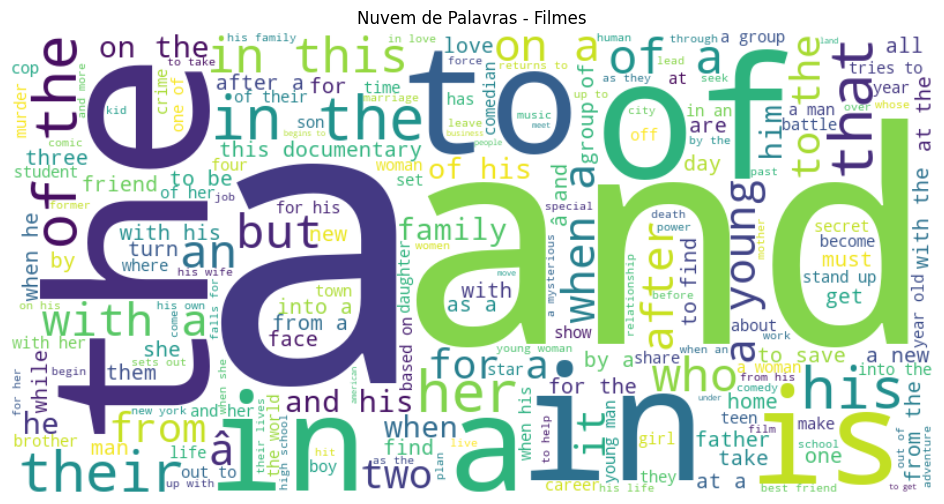

In [72]:
wordcloud_movies = WordCloud(
    width=800,
    height=400,
    background_color="white",
    stopwords="english"
).generate(movies_text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_movies, interpolation="bilinear")
plt.axis("off")
plt.title("Nuvem de Palavras - Filmes")
plt.show()


3. Criar a nuvem de palavras – Séries

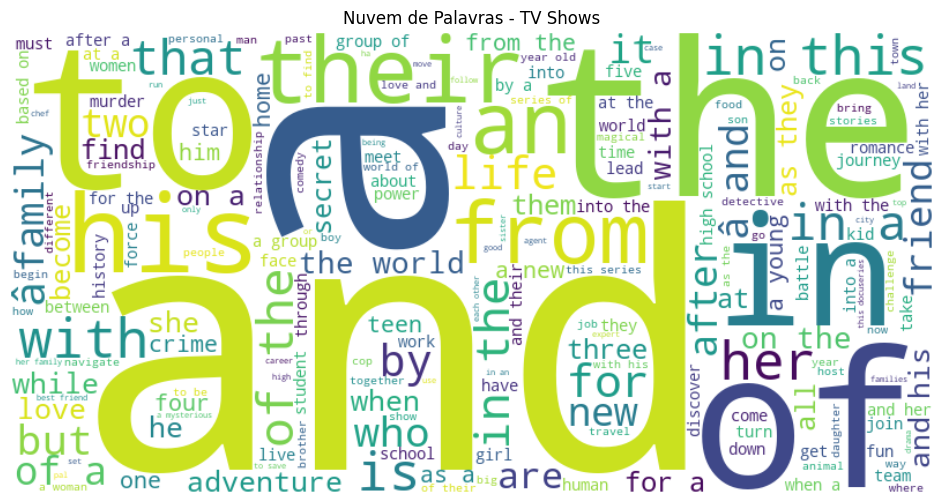

In [73]:
wordcloud_tv = WordCloud(
    width=800,
    height=400,
    background_color="white",
    stopwords="english"
).generate(tv_text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_tv, interpolation="bilinear")
plt.axis("off")
plt.title("Nuvem de Palavras - TV Shows")
plt.show()


Como análise exploratória adicional, foram geradas nuvens de palavras a partir das descrições dos títulos. As visualizações permitem identificar termos mais frequentes em filmes e séries, auxiliando na compreensão dos temas recorrentes presentes no conjunto de dados.
